In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### The purpose of this notebook is to explore using dgl libaray for GAT implementation

In [2]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import numpy as np
from tqdm import tqdm

pd.set_option('display.max_rows', 100)

#### Get all the relevant graphs

In [3]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    

# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


##### Convert networkx graphs to dgl graph objects, then put it into a dataset

In [4]:
from patch_gnn.dgl_dataset import get_graph_and_feat_df,convert_networkx_to_dgl,PatchGNNDataset

Using backend: pytorch


In [5]:
all_networkx_graphs, all_graph_features, accession_num = get_graph_and_feat_df(graphs, processed_data)
all_networkx_graphs = [graph.to_directed() for graph in all_networkx_graphs]
targets = processed_data['ox_fwd_logit'].values
train_dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs[:251],
                 labels = targets[:251],
                 features= all_graph_features[:251])
test_dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs[251:],
                 labels = targets[251:],
                 features= all_graph_features[251:])


100%|██████████| 108/108 [00:00<00:00, 2920.47it/s]


In [6]:
# indexing datasets returns dgl_graph, target value and node names
one_dgl_graph, one_graph_node, one_graph_label = train_dataset[4]

print(f"dataset 0 nodes is {one_graph_node}, target is {one_graph_label}")
one_dgl_nodes = list(one_graph_node.values())

dataset 0 nodes is {0: '402CYS', 1: '405ILE', 2: '409LEU', 3: '437ASP', 4: '438MET', 5: '439ILE', 6: '442TRP', 7: '573LEU', 8: '576ILE'}, target is -3.8092901706695557


#### Construct a GATN model
Import relevant modules

In [7]:
from patch_gnn.dgl_layer import GATN
from patch_gnn.dgl_dataset import collate_fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from dgl.dataloading import GraphDataLoader
import dgl
from patch_gnn.dgl_cv_split import k_fold_split

##### Add cross validation split

In [8]:
all_folds = k_fold_split(train_dataset, k=3)
for train_fold, val_fold in all_folds:
    print(len(train_fold), len(val_fold))
len(all_folds[0][0]), len(all_folds[0][1]), all_folds[0][0][0]

168 83
167 84
167 84


(168,
 83,
 (Graph(num_nodes=5, num_edges=16,
        ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
        edata_schemes={}),
  {0: '331ILE', 1: '332ASP', 2: '333MET', 3: '334LEU', 4: '335LEU'},
  tensor(-1.4289)))

#### Get cross validation performance

In [9]:
from patch_gnn.dgl_train_gatn import reset_weights, cv_on_train_with_gatn

100%|██████████| 7000/7000 [01:44<00:00, 67.08it/s]


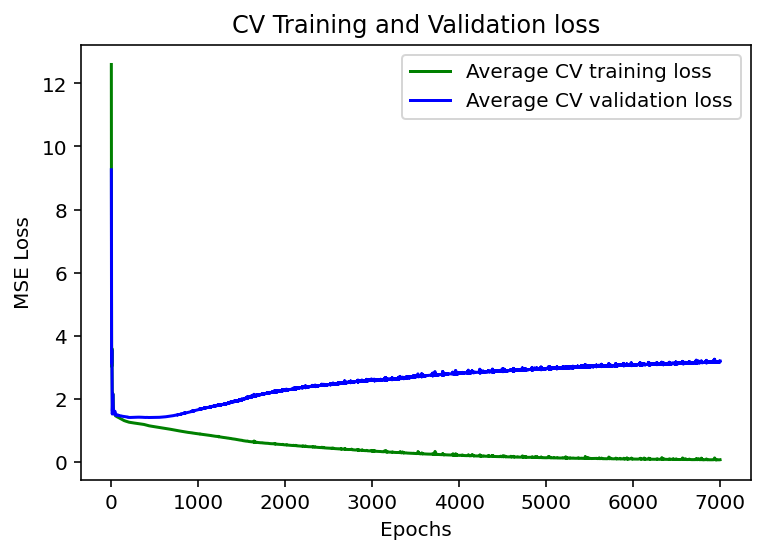

In [11]:
lr = 1e-4
avg_loss_per_epoch_train, avg_loss_per_epoch_val = cv_on_train_with_gatn(
    train_dataset,
    lr = lr,
    n_epochs = 7000
)

##### Based on the cross validation performance from the above, select appropriate number of epochs for training, then save the trained model to file 

In [12]:
from patch_gnn.dgl_train_gatn import train_val_with_gatn_no_cv
train_loader = GraphDataLoader(train_dataset, batch_size = len(train_dataset), collate_fn =collate_fn)
test_loader = GraphDataLoader(test_dataset, batch_size = len(test_dataset), collate_fn =collate_fn)

In [25]:
n_epochs = 1000
train_val_with_gatn_no_cv(
    lr_lst = [lr],
    train_loader = train_loader,
    test_loader =  test_loader,
    save_checkpoint = True,
    n_epochs = n_epochs
)

100%|██████████| 1000/1000 [00:17<00:00, 55.81it/s]


#### load saved model and re-evaluate on test set
below code block can be optimized

In [48]:
net = torch.load(f"best_gatn_{lr}.pkl")
net.eval()
mse_loss = nn.MSELoss()
train_loader = GraphDataLoader(train_dataset, batch_size = len(train_dataset), collate_fn =collate_fn)
for train_graphs, train_targets in train_loader:
    pred_train_target, _ = net(train_graphs, 
                 train_graphs.ndata["feat"]) 
    # both pred and train labels are tensor.size([1])
    train_actual_loss = mse_loss(pred_train_target.float(), train_targets.float().unsqueeze(1))

test_loader = GraphDataLoader(test_dataset, batch_size = len(test_dataset), collate_fn =collate_fn)
for test_graphs, test_targets in test_loader:
    pred_test_target, _ = net(test_graphs, 
                 test_graphs.ndata["feat"]) 
    # both pred and train labels are tensor.size([1])
    test_actual_loss = mse_loss(pred_test_target.float(), test_targets.float().unsqueeze(1))

# get attention
# use batch_size =1, get list and append attention to the list
attention_list = list()
test_loss_list = list()

for test_idx in range(len(test_dataset)):
    one_graph, one_graph_nodes, one_graph_target = test_dataset[test_idx]
    pred_one_target, attention = net(one_graph, one_graph.ndata["feat"]) 
    attention_list.append(attention)
    test_one_loss = mse_loss(pred_one_target.float()[0][0], 
                             one_graph_target.float())
    test_loss_list.append(test_one_loss)

##### get performance metric

In [49]:
from scipy.stats import pearsonr
train_pearsonr, train_pearsonr_p = pearsonr(pred_train_target.detach().numpy().squeeze(), train_targets.squeeze())
test_pearsonr, test_pearsonr_p = pearsonr(pred_test_target.detach().numpy().squeeze(), test_targets.squeeze())
print(f"the pearson correlation on train set is {train_pearsonr}, p value is {train_pearsonr_p}")
print(f"the pearson correlation on test set is {test_pearsonr}, p value is {test_pearsonr_p}")

the pearson correlation on train set is 0.6197996971918219, p value is 4.987768823053766e-28
the pearson correlation on test set is -0.03667159694463879, p value is 0.7063262355639754


Text(0.5, 1.0, 'GATN, Test Perf: -0.301')

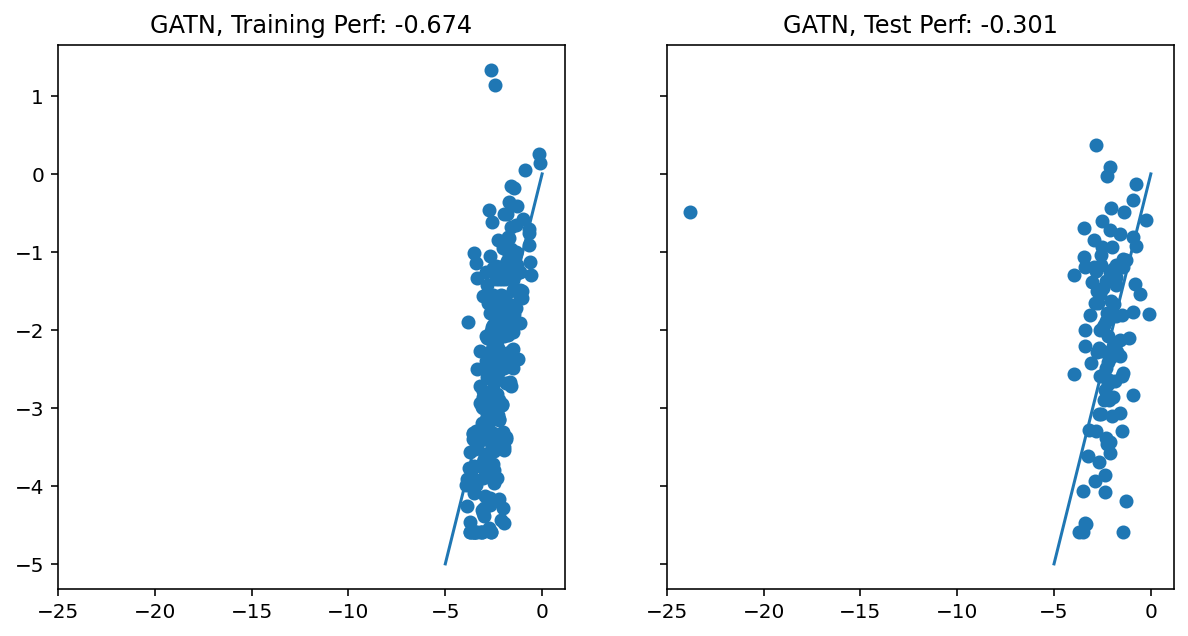

In [40]:
fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
ax[0].scatter(pred_train_target.detach().numpy().squeeze(), train_targets.squeeze())
ax[0].plot([-5, 0], [-5, 0])
ax[0].set_title(f"GATN, Training Perf: {evs(pred_train_target.detach().numpy().squeeze(), train_targets.squeeze()):.3f}")

ax[1].scatter(pred_test_target.detach().numpy().squeeze(), test_targets.squeeze())
ax[1].plot([-5, 0], [-5, 0])
ax[1].set_title(f"GATN, Test Perf: {evs(pred_test_target.detach().numpy().squeeze(), test_targets.squeeze()):.3f}")

##### draw attention derived from the model on selected graphs

In [50]:
from patch_gnn.dgl_train_gatn import get_attention_plot

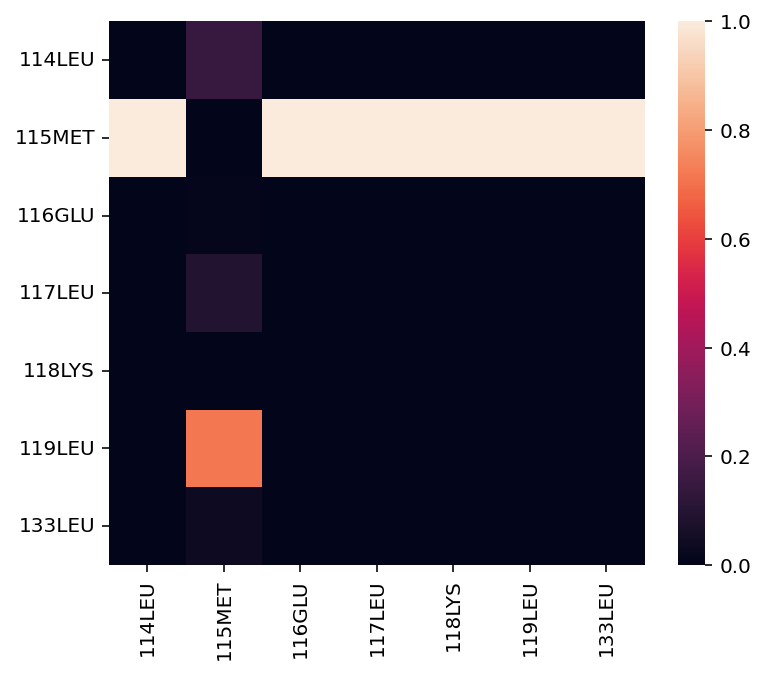

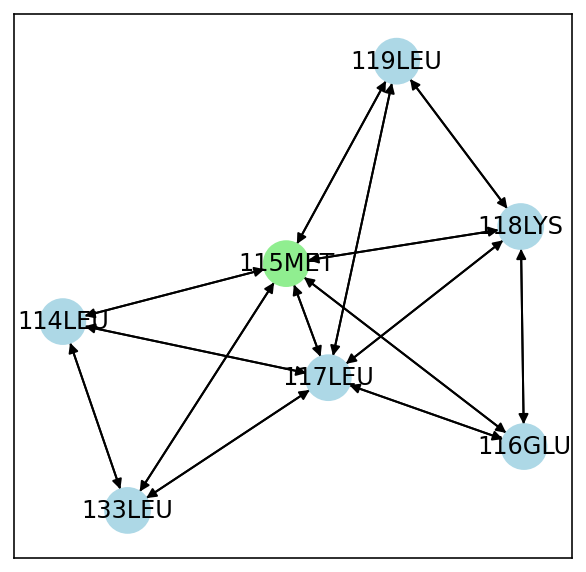

In [51]:
a3 =get_attention_plot(test_dataset =test_dataset, idx = 3, attention_list =attention_list )

In [53]:
#visualize attention matrix
pd.DataFrame(a3)

,0,1,2,3,4,5,6
0,0.000000e+00,0.147832,0.000000e+00,5.859046e-14,0.000000e+00,0.000000e+00,5.859001e-14
1,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2,0.000000e+00,0.008461,0.000000e+00,3.353277e-15,3.353277e-15,0.000000e+00,0.000000e+00
3,3.632238e-14,0.091647,3.632238e-14,0.000000e+00,3.632251e-14,3.632224e-14,3.632224e-14
4,0.000000e+00,0.000074,2.923941e-17,2.923951e-17,0.000000e+00,2.923929e-17,0.000000e+00
5,0.000000e+00,0.717614,0.000000e+00,2.844134e-13,2.844134e-13,0.000000e+00,0.000000e+00
6,1.362320e-14,0.034373,0.000000e+00,1.362326e-14,0.000000e+00,0.000000e+00,0.000000e+00


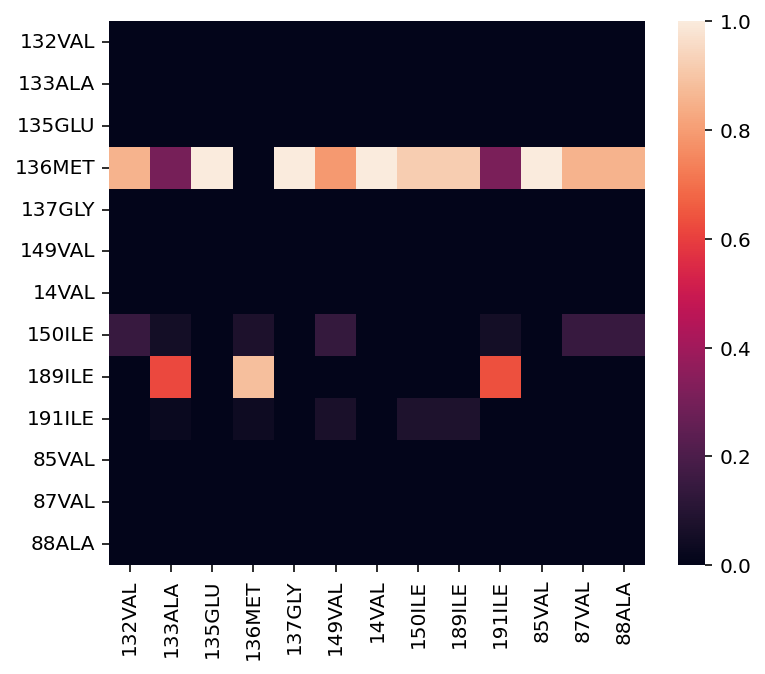

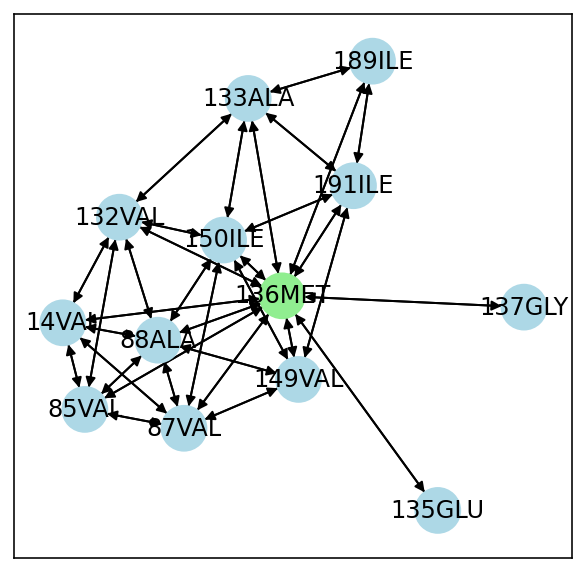

In [55]:
a20 = get_attention_plot(test_dataset =test_dataset, idx = 20, attention_list =attention_list )

In [57]:
#visualize attention matrix
pd.DataFrame(a20)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000e+00,1.022827e-07,0.0,1.465878e-07,0.0,0.000000e+00,3.384116e-07,3.109024e-07,0.000000e+00,0.000000e+00,3.384102e-07,0.000000e+00,2.884244e-07
1,4.773085e-10,0.000000e+00,0.0,2.425845e-10,0.0,0.000000e+00,0.000000e+00,5.145046e-10,5.145050e-10,1.739161e-10,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.0,3.080397e-13,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,8.522888e-01,3.022432e-01,1.0,0.000000e+00,1.0,7.925231e-01,9.999990e-01,9.187099e-01,9.187107e-01,3.105482e-01,9.999988e-01,8.522886e-01,8.522881e-01
4,0.000000e+00,0.000000e+00,0.0,2.290223e-20,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,0.000000e+00,0.000000e+00,0.0,8.507575e-08,0.0,0.000000e+00,0.000000e+00,1.804396e-07,0.000000e+00,6.099337e-08,0.000000e+00,1.673935e-07,1.673940e-07
6,3.999845e-07,0.000000e+00,0.0,2.032858e-07,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.693022e-07,3.999814e-07,3.999827e-07
7,1.477106e-01,5.238193e-02,0.0,7.507187e-02,0.0,1.373526e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.382128e-02,0.000000e+00,1.477106e-01,1.477105e-01
8,0.000000e+00,6.186317e-01,0.0,8.866003e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.356304e-01,0.000000e+00,0.000000e+00,0.000000e+00
9,0.000000e+00,2.674305e-02,0.0,3.832716e-02,0.0,7.012395e-02,0.000000e+00,8.128919e-02,8.128927e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
